In [1]:
# imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.feature_selection import (
    SelectKBest,
    RFE,
    f_regression,
    SequentialFeatureSelector,
)
from sklearn.preprocessing import (
    MinMaxScaler,
    StandardScaler,
    RobustScaler,
    PolynomialFeatures,
)
import matplotlib as mpl
import wrangle as w
import warnings
warnings.filterwarnings("ignore")

mpl.rcParams["axes.formatter.useoffset"] = False
mpl.rcParams["axes.formatter.limits"] = (-1_000_000, 1_000_000)

In [2]:
from env import user, password, host
import os

def get_zillow(user=user, password=password, host=host):
    """
    This function acquires data from a SQL database of 2017 Zillow properties and caches it locally.

    :param user: The username for accessing the MySQL database
    :param password: The password is unique per user saved in env
    :param host: The host parameter is the address of the server where the Zillow database is hosted
    :return: The function `get_zillow` is returning a pandas DataFrame containing information on single family residential properties
    """
    # name of cached csv
    filename = "zillow.csv"
    # if cached data exist
    if os.path.isfile(filename):
        # read data from cached csv
        df = pd.read_csv(filename)
    # wrangle from sql db if not cached
    else:
        # read sql query into df
        # 261 is single family residential id
        df = pd.read_sql(
            """select * 
                            from properties_2017 
                            left join predictions_2017 using(parcelid) 
                            where propertylandusetypeid in (261,279)""",
            f"mysql+pymysql://{user}:{password}@{host}/zillow",
        )
        # filter to just 2017 transactions
        df = df[df["transactiondate"].str.startswith("2017", na=False)]
        # cache data locally
        df.to_csv(filename, index=False)
    return df

In [3]:
# Pull data and verify size
df = get_zillow()

df.shape

(52441, 62)

In [4]:
import pandas as pd

def explore_prep_zillow(df):
    """
    Prepare uncleaned Zillow dataframe for exploration.

    Args:
        df (pandas.DataFrame): uncleaned Zillow dataframe

    Returns:
        pandas.DataFrame: cleaned Zillow dataframe
    """
    # Replace missing values with appropriate values or 0 where it makes sense
    df = df.fillna(
        {
            "numberofstories": 0,
            "fireplaceflag": 0,
            "yardbuildingsqft26": 0,
            "yardbuildingsqft17": 0,
            "unitcnt": 0,
            "threequarterbathnbr": 0,
            "pooltypeid7": 0,
            "pooltypeid2": 0,
            "pooltypeid10": 0,
            "poolsizesum": 0,
            "poolcnt": 0,
            "hashottuborspa": 0,
            "garagetotalsqft": 0,
            "garagecarcnt": 0,
            "fireplacecnt": 0,
            "lotsizesquarefeet": df["calculatedfinishedsquarefeet"],
        }
    )

    # Split transaction date to year, month, and day
    df_split = df["transactiondate"].str.split(pat="-", expand=True).add_prefix("trx_")
    df = pd.concat([df.iloc[:, :40], df_split, df.iloc[:, 40:]], axis=1)

    # Rename columns
    df = df.rename(
        columns=(
            {
                "yearbuilt": "year",
                "bedroomcnt": "beds",
                "bathroomcnt": "baths",
                "calculatedfinishedsquarefeet": "area",
                "taxvaluedollarcnt": "prop_value",
                "fips": "county",
                "trx_1": "trx_month",
                "trx_2": "trx_day",
                "numberofstories": "stories",
                "poolcnt": "pools",
            }
        )
    )

    # Filter out/drop columns that have too many nulls, are related to target, are dupes, or have no use for exploration or modeling
    df = df.drop(
        columns=[
            "id",
            "airconditioningtypeid",
            "architecturalstyletypeid",
            "basementsqft",
            "buildingclasstypeid",
            "buildingqualitytypeid",
            "calculatedbathnbr",
            "decktypeid",
            "finishedfloor1squarefeet",
            "finishedsquarefeet12",
            "finishedsquarefeet13",
            "finishedsquarefeet15",
            "finishedsquarefeet50",
            "finishedsquarefeet6",
            "fullbathcnt",
            "heatingorsystemtypeid",
            "lotsizesquarefeet",
            "pooltypeid10",
            "pooltypeid2",
            "pooltypeid7",
            "propertycountylandusecode",
            "propertylandusetypeid",
            "propertyzoningdesc",
            "rawcensustractandblock",
            "regionidcity",
            "regionidcounty",
            "regionidneighborhood",
            "regionidzip",
            "storytypeid",
            "threequarterbathnbr",
            "typeconstructiontypeid",
            "yardbuildingsqft17",
            "yardbuildingsqft26",
            "structuretaxvaluedollarcnt",
            "assessmentyear",
            "landtaxvaluedollarcnt",
            "taxamount",
            "taxdelinquencyflag",
            "taxdelinquencyyear",
            "censustractandblock",
            "id.1",
            "logerror",
        ]
    )

    # Drop nulls
    df = df.dropna()

    # Map county to fips
    df.county = df.county.map({6037: "LA", 6059: "Orange", 6111: "Ventura"})

    # Convert certain columns to int
    ints = ["year", "beds", "area", "prop_value", "trx_month", "trx_day"]
    for i in ints:
        df[i] = df[i].astype(int)

    # Sort by column: 'transactiondate' (descending) for dropping dupes keeping recent
    df = df.sort_values(["transactiondate"], ascending=[False])

    # Drop duplicate rows in column: 'parcelid', keeping max trx date
    df = df.drop_duplicates(subset=["parcelid"])

    # Add features
    df = df.assign(age=2017 - df.year)

    # Sort columns and index
    df = df[
        [
            "prop_value",
            "area",
            "year",
            "age",
            "baths",
            "beds",
            "roomcnt",
            "county",
            "latitude",
            "longitude",
        ]
    ].sort_index()

    # Get 1% and 99% quantiles of the target column
    q1 = df.prop_value.quantile(0.01)
    q99 = df.prop_value.quantile(0.99)

    # Filter out the outliers
    df = df[(df.prop_value >= q1) & (df.prop_value <= q99)]

    return df

In [5]:
df = explore_prep_zillow(df)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 51156 entries, 0 to 52440
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   prop_value  51156 non-null  int64  
 1   area        51156 non-null  int64  
 2   year        51156 non-null  int64  
 3   age         51156 non-null  int64  
 4   baths       51156 non-null  float64
 5   beds        51156 non-null  int64  
 6   roomcnt     51156 non-null  float64
 7   county      51156 non-null  object 
 8   latitude    51156 non-null  float64
 9   longitude   51156 non-null  float64
dtypes: float64(4), int64(5), object(1)
memory usage: 4.3+ MB


In [8]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
prop_value,51156.0,4.834589e+05,437530.957965,37433.0,1.976420e+05,373618.0,6.105225e+05,3096141.0
area,51156.0,1.896182e+03,901.557590,128.0,1.274000e+03,1659.0,2.291250e+03,11020.0
year,51156.0,1.963582e+03,22.878084,1878.0,1.950000e+03,1961.0,1.979000e+03,2016.0
age,51156.0,5.341790e+01,22.878084,1.0,3.800000e+01,56.0,6.700000e+01,139.0
baths,51156.0,2.285421e+00,0.958728,0.0,2.000000e+00,2.0,3.000000e+00,10.0
beds,51156.0,3.303425e+00,0.920134,0.0,3.000000e+00,3.0,4.000000e+00,12.0
roomcnt,51156.0,1.918172e+00,3.156980,0.0,0.000000e+00,0.0,5.000000e+00,14.0
latitude,51156.0,3.402348e+07,275141.272792,33340620.0,3.382624e+07,34023059.0,3.418928e+07,34818767.0
longitude,51156.0,-1.181926e+08,357203.030980,-119475416.0,-1.183996e+08,-118149166.0,-1.179281e+08,-117554636.0


## Surface Level Exploration

In [6]:
# For the first iteration of your model, use only square feet of the home, number of bedrooms, and number of bathrooms 
# to estimate the property's assessed value, taxvaluedollarcnt. 

# You can expand this to other fields after you have completed an MVP (minimally viable product).

df = df[["baths", "beds", "area", "prop_value"]]

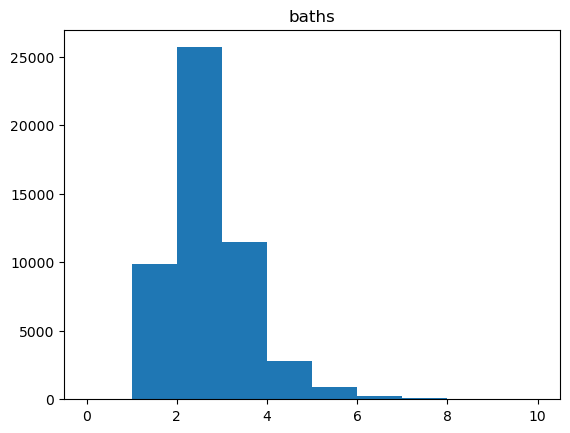

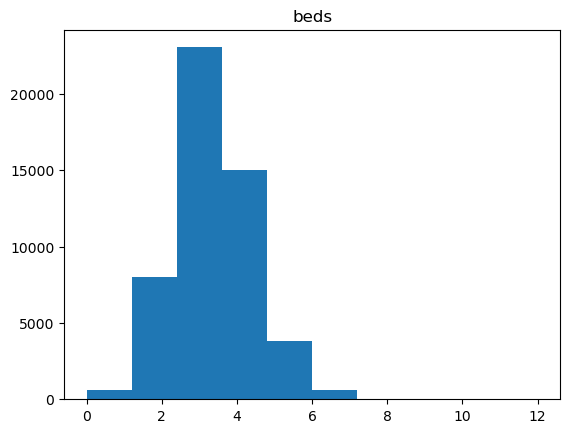

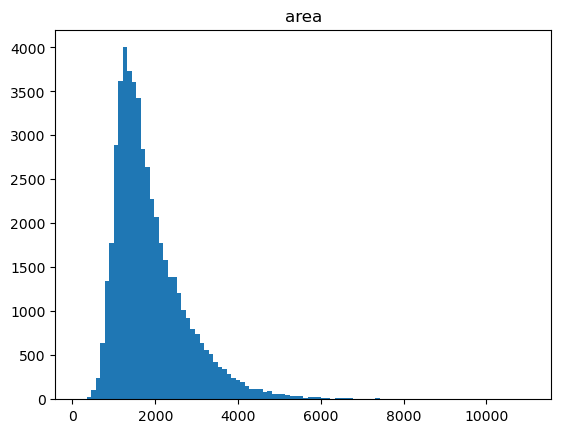

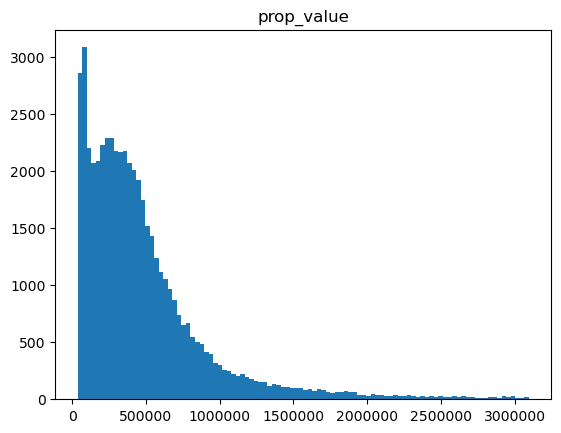

In [10]:
# Plot histograms for columns

for col in ["baths", "beds"]:
    plt.hist(df[col])
    plt.title(col)
    plt.show()
    
# Make the histograms bins large enough for bigger values
for col in ["area", "prop_value"]:
    plt.hist(df[col], 100)
    plt.title(col)
    plt.show()

In [7]:
def split_data(df):
    """Split into train, validate, test with a 60% train, 20% validate, 20% test"""
    train_validate, test = train_test_split(df, test_size=0.2, random_state=123)
    train, validate = train_test_split(train_validate, test_size=0.25, random_state=123)

    print(f"train: {len(train)} ({round(len(train)/len(df)*100)}% of {len(df)})")
    print(
        f"validate: {len(validate)} ({round(len(validate)/len(df)*100)}% of {len(df)})"
    )
    print(f"test: {len(test)} ({round(len(test)/len(df)*100)}% of {len(df)})")
    return train, validate, test

In [8]:
train, val, test = split_data(df)

train: 30693 (60% of 51156)
validate: 10231 (20% of 51156)
test: 10232 (20% of 51156)


In [13]:
train.describe()

,baths,beds,area,prop_value
count,30693.000000,30693.000000,30693.000000,3.069300e+04
mean,2.286971,3.302447,1894.447431,4.826310e+05
std,0.955128,0.917689,896.486317,4.400233e+05
min,0.000000,0.000000,152.000000,3.743300e+04
25%,2.000000,3.000000,1274.000000,1.957680e+05
50%,2.000000,3.000000,1658.000000,3.713630e+05
75%,3.000000,4.000000,2291.000000,6.100000e+05
max,9.000000,12.000000,11020.000000,3.096141e+06


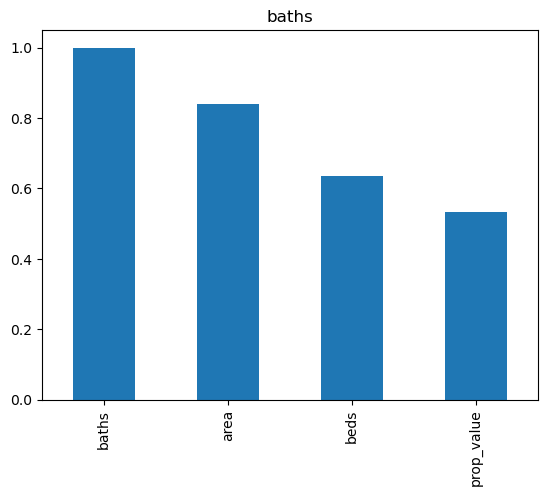

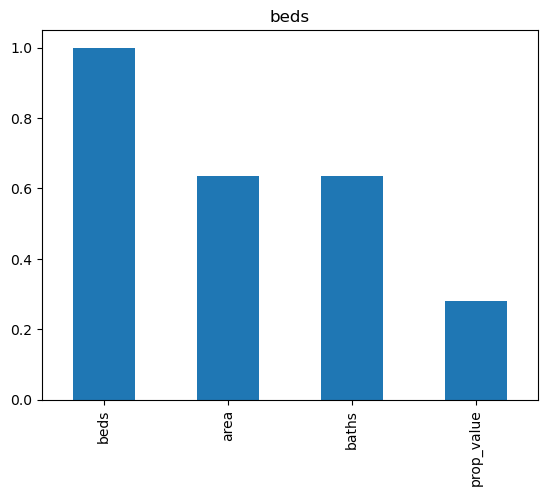

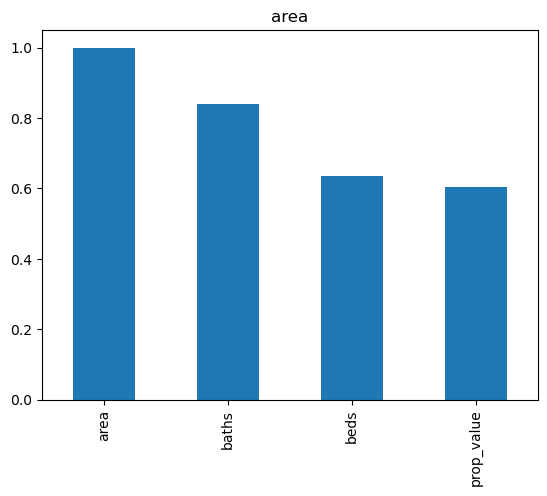

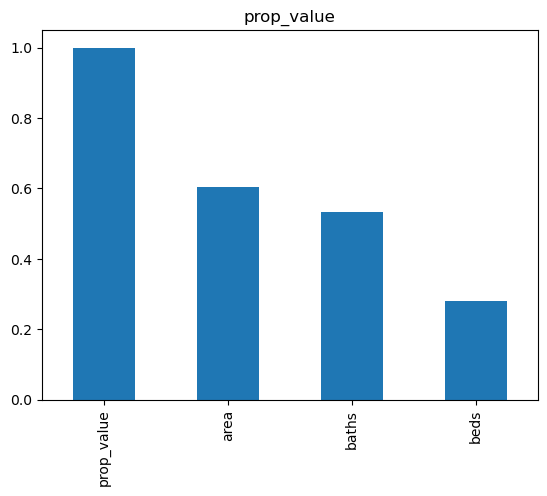

In [14]:
cols = train.columns.to_list()
for col in cols:
    train.corr()[col].sort_values(ascending=False).plot(kind="bar")
    plt.title(col)
    plt.show()

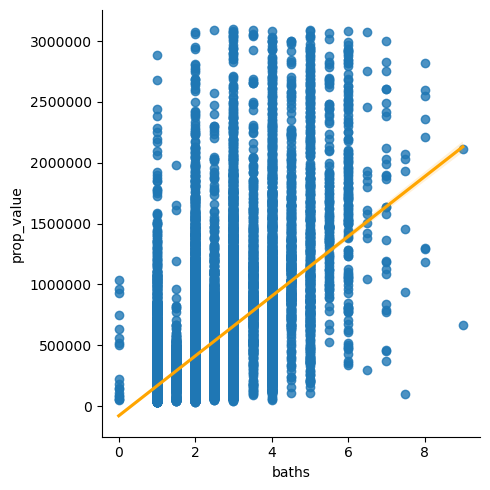

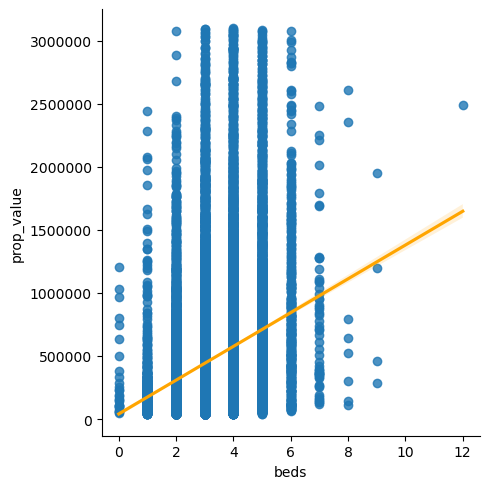

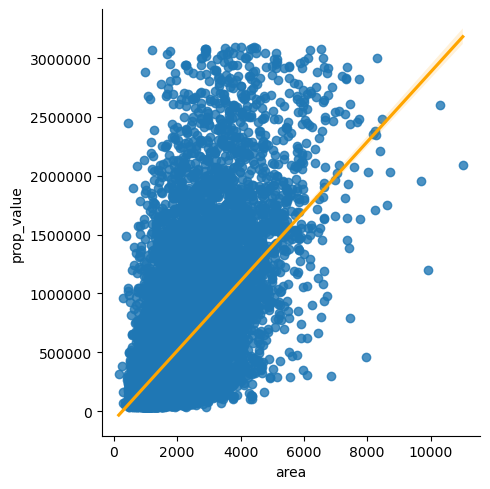

In [15]:
target = "prop_value"
for i in train.drop(columns=target):
    sns.lmplot(x=i, y=target, data=train, line_kws={"color": "orange"})
    # plt.ylim(0,20_000_000)
    plt.show()

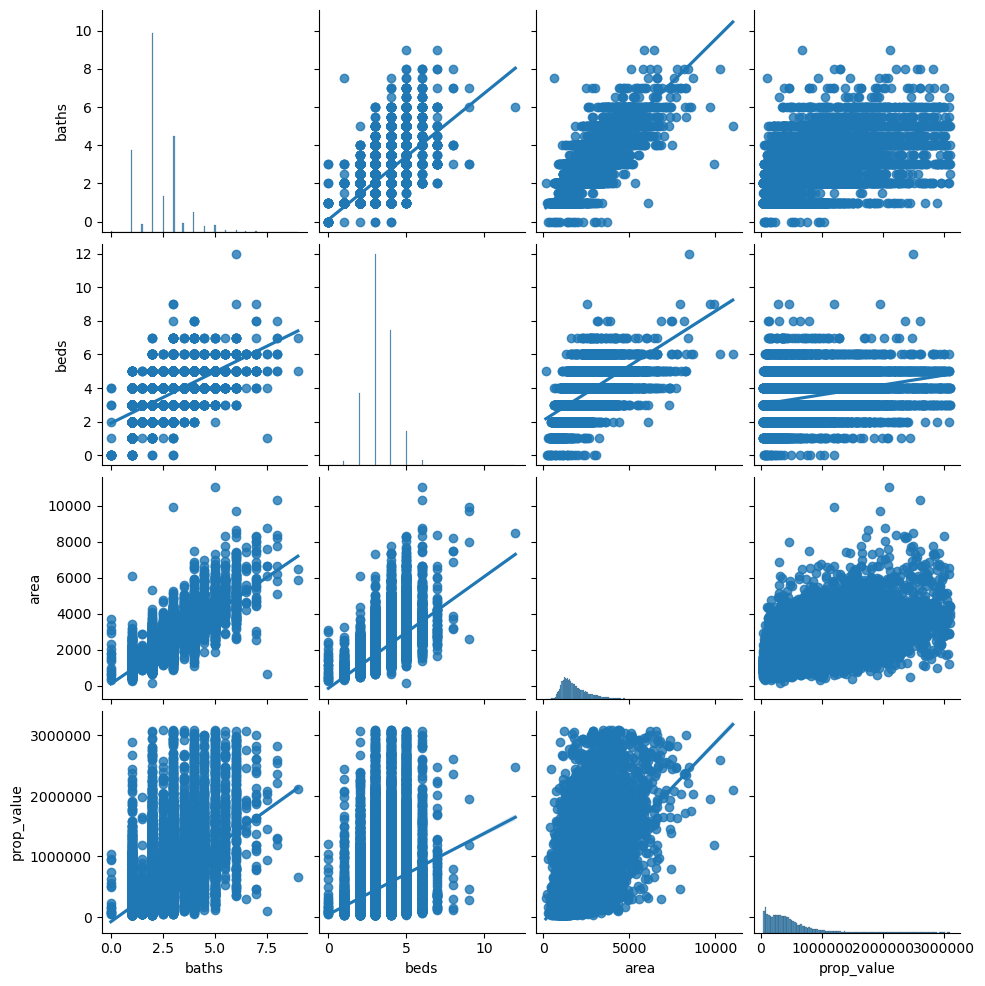

In [14]:
sns.pairplot(data=train, kind="reg")
plt.show()

In [16]:
import itertools

cols = train.columns.to_list()

def pear(train, x, y, alt_hyp="two-sided"):
    r, p = stats.spearmanr(train[x], train[y], alternative=alt_hyp)
    print(f"Spearman's R: {x} and {y}\n", f"r = {r}, p = {p}\n")


for col in itertools.permutations(cols, 2):
    # cont & cont
    pear(train, col[0], col[1])

Spearman's R: baths and beds
 r = 0.6292948883518316, p = 0.0

Spearman's R: baths and area
 r = 0.8335628899850854, p = 0.0

Spearman's R: baths and prop_value
 r = 0.4668280371919439, p = 0.0

Spearman's R: beds and baths
 r = 0.6292948883518316, p = 0.0

Spearman's R: beds and area
 r = 0.6615937474938139, p = 0.0

Spearman's R: beds and prop_value
 r = 0.27359198859932937, p = 0.0

Spearman's R: area and baths
 r = 0.8335628899850854, p = 0.0

Spearman's R: area and beds
 r = 0.6615937474938139, p = 0.0

Spearman's R: area and prop_value
 r = 0.5046723880332488, p = 0.0

Spearman's R: prop_value and baths
 r = 0.4668280371919439, p = 0.0

Spearman's R: prop_value and beds
 r = 0.2735919885993293, p = 0.0

Spearman's R: prop_value and area
 r = 0.5046723880332488, p = 0.0



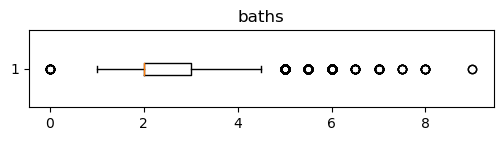

Number of results in lower quartile: 18 (0.06%)
Number of results in inner quartile: 29940 (97.55%)
Number of results in upper quartile: 735 (2.39%)


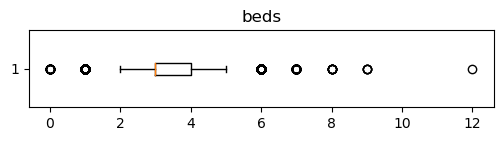

Number of results in lower quartile: 343 (1.12%)
Number of results in inner quartile: 29947 (97.57%)
Number of results in upper quartile: 403 (1.31%)


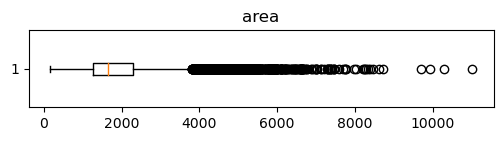

Number of results in lower quartile: 0 (0.00%)
Number of results in inner quartile: 29520 (96.18%)
Number of results in upper quartile: 1173 (3.82%)


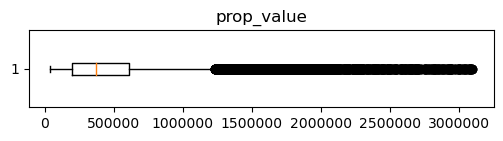

Number of results in lower quartile: 0 (0.00%)
Number of results in inner quartile: 28809 (93.86%)
Number of results in upper quartile: 1884 (6.14%)


In [17]:
def box_plotter(df):
    """
    Generates a box plot for all columns in a dataframe using matplotlib.
    """
    for col in df.columns:
        try:
            plt.figure(figsize=(6, 1))
            plt.boxplot(df[col], vert=False)
            plt.title(col)
            plt.show()
            q1 = df[col].quantile(0.25)
            q3 = df[col].quantile(0.75)
            iqr = q3 - q1
            lower_bound = q1 - 1.5 * iqr
            upper_bound = q3 + 1.5 * iqr
            print(
                f"Number of results in lower quartile: {len(df[df[col] < lower_bound])} ({(len(df[df[col] < lower_bound])/len(df))*100:.2f}%)"
            )
            print(
                f"Number of results in inner quartile: {len(df[(df[col] >= lower_bound) & (df[col] <= upper_bound)])} ({(len(df[(df[col] >= lower_bound) & (df[col] <= upper_bound)])/len(df))*100:.2f}%)"
            )
            print(
                f"Number of results in upper quartile: {len(df[df[col] > upper_bound])} ({(len(df[df[col] > upper_bound])/len(df))*100:.2f}%)"
            )
        except:
            print(
                f"Error: Could not generate box plot for column {col}. Skipping to next column..."
            )
            plt.close()
            continue

box_plotter(train)

### Does area correlate with prop_value?
- H0 = No correlation
- Ha = Yes correlation

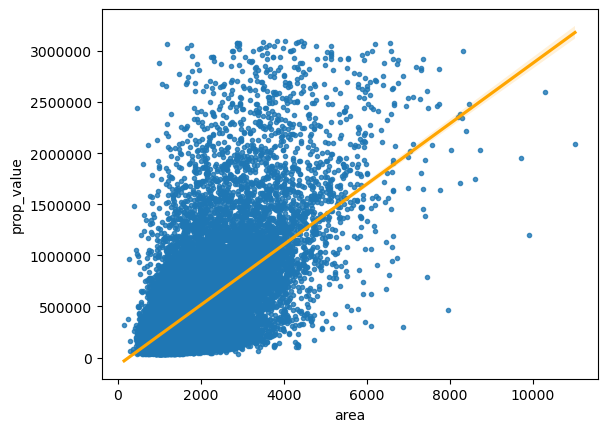

In [18]:
sns.regplot(
    data=train, x="area", y="prop_value", marker=".", line_kws={"color": "orange"}
)
plt.show()

In [18]:
pear(train, "area", "prop_value")

Spearman's R: area and prop_value
 r = 0.5046723880332488, p = 0.0



- less than alpha = .05
- yes correlation

### Does baths correlate with prop_value?
- H0 = No correlation
- Ha = Yes correlation

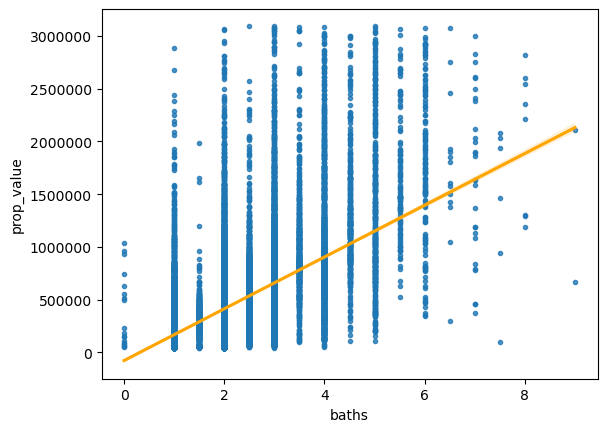

In [19]:
sns.regplot(
    data=train, x="baths", y="prop_value", marker=".", line_kws={"color": "orange"}
)
plt.show()

In [20]:
pear(train, "baths", "prop_value")

Spearman's R: baths and prop_value
 r = 0.4668280371919439, p = 0.0



In [21]:
# less than alpha = .05
# yes correlation

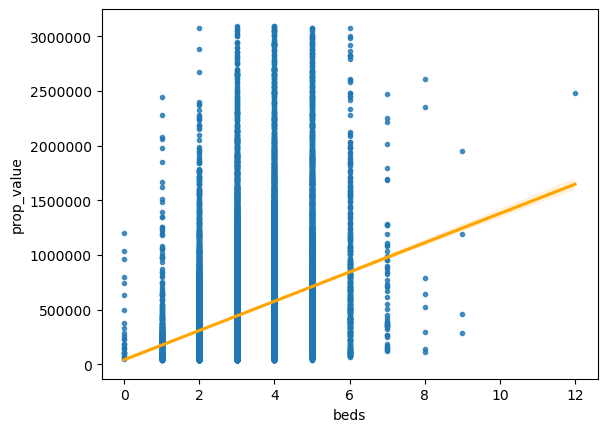

In [21]:
# Does beds correlate with prop_value?
# H0 = No correlation
# Ha = Yes correlation
sns.regplot(
    data=train, x="beds", y="prop_value", marker=".", line_kws={"color": "orange"}
)
plt.show()

In [22]:
pear(train, "beds", "prop_value")

Spearman's R: beds and prop_value
 r = 0.27359198859932937, p = 0.0



In [24]:
# less than alpha = .05
# yes correlation

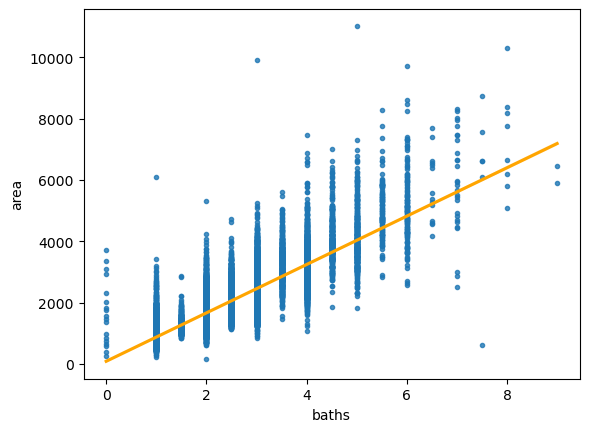

In [23]:
# Does baths correlate with area?
# H0 = No correlation
# Ha = Yes correlation
sns.regplot(data=train, x="baths", y="area", marker=".", line_kws={"color": "orange"})
plt.show()

In [24]:
pear(train, "baths", "area")

Spearman's R: baths and area
 r = 0.8335628899850854, p = 0.0



In [25]:
# less than alpha = .05
# yes correlation

In [9]:
# Add a new column to the train dataframe that contains the sum of the beds and baths columns
train = train.assign(beds_plus_baths=(train.beds + train.baths))

# Add a new column to the validation dataframe that contains the sum of the beds and baths columns
val = val.assign(beds_plus_baths=(val.beds + val.baths))

# Add a new column to the test dataframe that contains the sum of the beds and baths columns
test = test.assign(beds_plus_baths=(test.beds + test.baths))

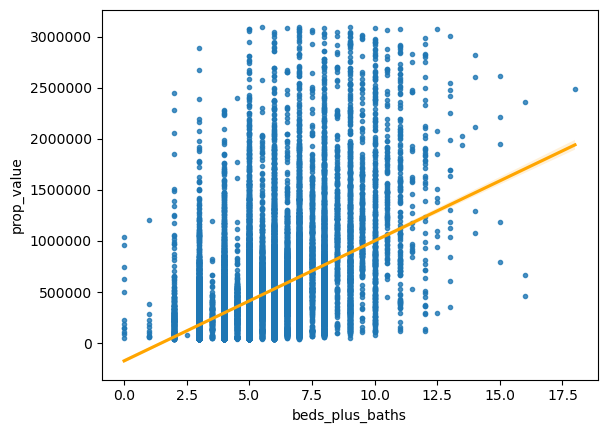

In [29]:
# Does baths correlate with area?
# H0 = No correlation
# Ha = Yes correlation
sns.regplot(
    data=train, x="beds_plus_baths", y="prop_value", marker=".", line_kws={"color": "orange"}
)
plt.show()

In [30]:
pear(train, "beds_plus_baths", "prop_value")

Spearman's R: beds_plus_baths and prop_value
 r = 0.4055682611004502, p = 0.0



In [31]:
# less than alpha = .05
# yes correlation

In [32]:
train.prop_value.mean()

482630.99700257386

In [10]:
# Generate X Splits

X_train, X_val, X_test = (
    train.drop(columns=["prop_value"]),
    val.drop(columns=["prop_value"]),
    test.drop(columns=["prop_value"]),
)

In [12]:
from sklearn.preprocessing import StandardScaler

def std_zillow(train, validate, test, scale=None):
    """
    Scale the numerical features of the train, validate, and test datasets using the Standard Scaler method.

    Args:
        train (pandas.DataFrame): training dataset
        validate (pandas.DataFrame): validation dataset
        test (pandas.DataFrame): test dataset
        scale (list): list of columns to scale (default is None, which scales all numerical columns)

    Returns:
        tuple: Xtr (scaled training data), Xv (scaled validation data), and Xt (scaled test data)
    """
    # If scale is None, scale all numerical columns
    if scale is None:
        scale = train.select_dtypes(include=["float64", "int64"]).columns.to_list()

    # Create a StandardScaler object
    std_scale = StandardScaler()

    # Create copies of the train, validate, and test dataframes
    Xtr, Xv, Xt = train.copy(), validate.copy(), test.copy()

    # Add "_std" to the column names of the columns to be scaled
    scale_std = [col + "_std" for col in scale]

    # Scale the columns in the train, validate, and test dataframes
    Xtr[scale_std] = std_scale.fit_transform(train[scale])
    Xv[scale_std] = std_scale.transform(validate[scale])
    Xt[scale_std] = std_scale.transform(test[scale])

    # Drop the unscaled columns from the train, validate, and test dataframes
    Xtr.drop(columns=scale, inplace=True)
    Xv.drop(columns=scale, inplace=True)
    Xt.drop(columns=scale, inplace=True)

    return Xtr, Xv, Xt

In [13]:
# Scale the numerical features of the train, validate, and test datasets using the Standard Scaler method.

scale = ['baths', 'beds', 'area', 'beds_plus_baths']
X_train_std, X_val_std, X_test_std = std_zillow(X_train, X_val, X_test, scale)

In [14]:
from sklearn.preprocessing import MinMaxScaler

def mm_zillow(train, validate, test, scale=None):
    """
    Scale the numerical features of the train, validate, and test datasets using the MinMax Scaler method.

    Args:
        train (pandas.DataFrame): training dataset
        validate (pandas.DataFrame): validation dataset
        test (pandas.DataFrame): test dataset
        scale (list): list of columns to scale (default is None, which scales all numerical columns)

    Returns:
        tuple: Xtr (scaled training data), Xv (scaled validation data), and Xt (scaled test data)
    """
    # If scale is None, scale all numerical columns
    if scale is None:
        scale = train.select_dtypes(include=["float64", "int64"]).columns.to_list()

    # Create a MinMaxScaler object
    mm_scale = MinMaxScaler()

    # Create copies of the train, validate, and test dataframes
    Xtr, Xv, Xt = train.copy(), validate.copy(), test.copy()

    # Add "_mm" to the column names of the columns to be scaled
    scale_mm = [col + "_mm" for col in scale]

    # Scale the columns in the train, validate, and test dataframes
    Xtr[scale_mm] = mm_scale.fit_transform(train[scale])
    Xv[scale_mm] = mm_scale.transform(validate[scale])
    Xt[scale_mm] = mm_scale.transform(test[scale])

    # Drop the unscaled columns from the train, validate, and test dataframes
    Xtr.drop(columns=scale, inplace=True)
    Xv.drop(columns=scale, inplace=True)
    Xt.drop(columns=scale, inplace=True)

    return Xtr, Xv, Xt

In [15]:
# Scale the numerical features of the train, validate, and test datasets using the MinMax Scaler method.

scale = ['baths', 'beds', 'area', 'beds_plus_baths']
X_train_mm, X_val_mm, X_test_mm = mm_zillow(X_train, X_val, X_test, scale)

In [16]:
from sklearn.preprocessing import RobustScaler

def rob_zillow(train, validate, test, scale=None):
    """
    Scale the numerical features of the train, validate, and test datasets using the Robust Scaler method.

    Args:
        train (pandas.DataFrame): training dataset
        validate (pandas.DataFrame): validation dataset
        test (pandas.DataFrame): test dataset
        scale (list): list of columns to scale (default is None, which scales all columns)

    Returns:
        tuple: Xtr (scaled training data), Xv (scaled validation data), and Xt (scaled test data)
    """
    # If scale is None, scale all columns
    if scale is None:
        scale = train.columns.to_list()

    # Create a RobustScaler object
    rob_scale = RobustScaler()

    # Create copies of the train, validate, and test dataframes
    Xtr, Xv, Xt = train.copy(), validate.copy(), test.copy()

    # Add "_rob" to the column names of the columns to be scaled
    scale_rob = [col + "_rob" for col in scale]

    # Scale the columns in the train, validate, and test dataframes
    Xtr[scale_rob] = rob_scale.fit_transform(train[scale])
    Xv[scale_rob] = rob_scale.transform(validate[scale])
    Xt[scale_rob] = rob_scale.transform(test[scale])

    # Drop the unscaled columns from the train, validate, and test dataframes
    Xtr.drop(columns=scale, inplace=True)
    Xv.drop(columns=scale, inplace=True)
    Xt.drop(columns=scale, inplace=True)

    return Xtr, Xv, Xt

In [17]:
# Scale the numerical features of the train, validate, and test datasets using the Robust Scaler method.

scale = ['baths', 'beds', 'area', 'beds_plus_baths']
X_train_rob, X_val_rob, X_test_rob = rob_zillow(X_train, X_val, X_test, scale)

In [18]:
# Generate Y Splits

y_train, y_val, y_test = (
    train[["prop_value"]],
    val[["prop_value"]],
    test[["prop_value"]],
)

In [19]:
# Establish Baseline with mean

y_train.mean()

prop_value    482630.997003
dtype: float64

In [20]:
from sklearn.metrics import mean_squared_error, r2_score

def metrics_reg(y_true, y_pred):
    """
    Calculate the root mean squared error (RMSE) and R-squared (R2) for a regression model.

    Args:
        y_true (array-like): true target values
        y_pred (array-like): predicted target values

    Returns:
        tuple: RMSE and R2
    """
    # Calculate the RMSE
    rmse = mean_squared_error(y_true, y_pred, squared=False)

    # Calculate the R2
    r2 = r2_score(y_true, y_pred)

    return rmse, r2

In [21]:
import itertools
import pandas as pd
from sklearn.linear_model import LinearRegression, LassoLars
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import TweedieRegressor

def reg_mods(Xtr, ytr, Xv, yv, features=None, alpha=1, degree=2, power=2):
    """
    Run multiple regression models with different feature combinations, hyperparameters, and output the results as a dataframe.

    Args:
        Xtr (pandas.DataFrame): training features
        ytr (pandas.DataFrame): training target
        Xv (pandas.DataFrame): validation features
        yv (pandas.DataFrame): validation target
        features (list): list of features to use in the models (default: all features)
        alpha (float or list): regularization strength for LassoLars and TweedieRegressor (default: 1)
        degree (int or list): degree of polynomial features for PolynomialFeatures (default: 2)
        power (float or list): power parameter for TweedieRegressor (default: 2)

    Returns:
        pandas.DataFrame: dataframe with the results of each model
    """
    if features is None:
        features = Xtr.columns.to_list()

    # Calculate baseline metrics using mean
    pred_mean = ytr.mean()[0]
    ytr_p = ytr.assign(pred_mean=pred_mean)
    yv_p = yv.assign(pred_mean=pred_mean)
    rmse_tr = mean_squared_error(ytr, ytr_p.pred_mean) ** 0.5
    rmse_v = mean_squared_error(yv, yv_p.pred_mean) ** 0.5
    r2_tr = r2_score(ytr, ytr_p.pred_mean)
    r2_v = r2_score(yv, yv_p.pred_mean)
    output = {
        "model": "bl_mean",
        "features": "None",
        "params": "None",
        "rmse_tr": rmse_tr,
        "rmse_v": rmse_v,
        "r2_tr": r2_tr,
        "r2_v": r2_v,
    }
    metrics = [output]

    # Iterate through feature combinations
    for r in range(1, (len(features) + 1)):
        # Cycle through feature combinations for linear regression
        for feature in itertools.combinations(features, r):
            f = list(feature)
            # Linear regression
            lr = LinearRegression()
            lr.fit(Xtr[f], ytr)
            # Metrics
            pred_lr_tr = lr.predict(Xtr[f])
            rmse_tr, r2_tr = metrics_reg(ytr, pred_lr_tr)
            pred_lr_v = lr.predict(Xv[f])
            rmse_v, r2_v = metrics_reg(yv, pred_lr_v)
            # Make it into a table for visualizing later
            output = {
                "model": "LinearRegression",
                "features": f,
                "params": "None",
                "rmse_tr": rmse_tr,
                "rmse_v": rmse_v,
                "r2_tr": r2_tr,
                "r2_v": r2_v,
            }
            metrics.append(output)

        # Cycle through feature combinations and alphas for LassoLars
        for feature, a in itertools.product(itertools.combinations(features, r), alpha):
            f = list(feature)
            # LassoLars
            ll = LassoLars(alpha=a, normalize=False, random_state=123)
            ll.fit(Xtr[f], ytr)
            # Metrics
            pred_ll_tr = ll.predict(Xtr[f])
            rmse_tr, r2_tr = metrics_reg(ytr, pred_ll_tr)
            pred_ll_v = ll.predict(Xv[f])
            rmse_v, r2_v = metrics_reg(yv, pred_ll_v)
            # Make it into a table for visualizing later
            output = {
                "model": "LassoLars",
                "features": f,
                "params": f"alpha={a}",
                "rmse_tr": rmse_tr,
                "rmse_v": rmse_v,
                "r2_tr": r2_tr,
                "r2_v": r2_v,
            }
            metrics.append(output)

        # Cycle through feature combinations and degrees for polynomial feature regression
        for feature, d in itertools.product(
            itertools.combinations(features, r), degree
        ):
            f = list(feature)
            # Polynomial feature regression
            pf = PolynomialFeatures(degree=d)
            Xtr_pf = pf.fit_transform(Xtr[f])
            Xv_pf = pf.transform(Xv[f])
            lp = LinearRegression()
            lp.fit(Xtr_pf, ytr)
            # Metrics
            pred_lp_tr = lp.predict(Xtr_pf)
            rmse_tr, r2_tr = metrics_reg(ytr, pred_lp_tr)
            pred_lp_v = lp.predict(Xv_pf)
            rmse_v, r2_v = metrics_reg(yv, pred_lp_v)
            # Make it into a table for visualizing later
            output = {
                "model": "PolynomialFeature",
                "features": f,
                "params": f"degree={d}",
                "rmse_tr": rmse_tr,
                "rmse_v": rmse_v,
                "r2_tr": r2_tr,
                "r2_v": r2_v,
            }
            metrics.append(output)

        # Cycle through feature combinations, alphas, and powers for TweedieRegressor
        for feature, a, p in itertools.product(
            itertools.combinations(features, r), alpha, power
        ):
            f = list(feature)
            # TweedieRegressor
            lm = TweedieRegressor(power=p, alpha=a)
            lm.fit(Xtr[f], ytr.prop_value)
            # Metrics
            pred_lm_tr = lm.predict(Xtr[f])
            rmse_tr, r2_tr = metrics_reg(ytr, pred_lm_tr)
            pred_lm_v = lm.predict(Xv[f])
            rmse_v, r2_v = metrics_reg(yv, pred_lm_v)
            # Make it into a table for visualizing later
            output = {
                "model": "TweedieRegressor",
                "features": f,
                "params": f"power={p},alpha={a}",
                "rmse_tr": rmse_tr,
                "rmse_v": rmse_v,
                "r2_tr": r2_tr,
                "r2_v": r2_v,
            }
            metrics.append(output)

    return pd.DataFrame(metrics)

In [22]:
# Run multiple regression models with different feature combinations, hyperparameters, and output the results as a dataframe.

# StandardScaler Models
metrics_std_scale = reg_mods(
    X_train_std,
    y_train,
    X_val_std,
    y_val,
    alpha=[1, 2, 3, 4, 5, 6, 7, 8, 9],
    degree=[2, 3, 4, 5],
    power=[1, 1.25, 1.5, 1.75, 2],
)

In [23]:
# Run multiple regression models with different feature combinations, hyperparameters, and output the results as a dataframe.

# MinMaxScaler Models
metrics_mm_scale = reg_mods(
    X_train_mm,
    y_train,
    X_val_mm,
    y_val,
    alpha=[1, 2, 3, 4, 5, 6, 7, 8, 9],
    degree=[2, 3, 4, 5],
    power=[1, 1.25, 1.5, 1.75, 2],
)

In [24]:
# Run multiple regression models with different feature combinations, hyperparameters, and output the results as a dataframe.

# RobustScaler Models
metrics_rob_scale = reg_mods(
    X_train_rob,
    y_train,
    X_val_rob,
    y_val,
    alpha=[1, 2, 3, 4, 5, 6, 7, 8, 9],
    degree=[2, 3, 4, 5],
    power=[1, 1.25, 1.5, 1.75, 2],
)

In [25]:
# Total Models Performed

metrics_std_scale.value_counts('model')

model
TweedieRegressor     675
LassoLars            135
PolynomialFeature     60
LinearRegression      15
bl_mean                1
Name: count, dtype: int64

In [26]:
# Total Models

metrics_mm_scale.value_counts('model')

model
TweedieRegressor     675
LassoLars            135
PolynomialFeature     60
LinearRegression      15
bl_mean                1
Name: count, dtype: int64

In [27]:
# Total Models

metrics_rob_scale.value_counts('model')

model
TweedieRegressor     675
LassoLars            135
PolynomialFeature     60
LinearRegression      15
bl_mean                1
Name: count, dtype: int64

In [28]:
# Total Models Ran 

(675*3)+(135*3)+(60*3)+(15*3)

2655

In [29]:
# Concatenate the dataframes along axis 1 (columns)

all_scales = pd.concat([metrics_rob_scale, metrics_mm_scale, metrics_std_scale], axis=0)

In [30]:
# Top 3 Polynomial (Sorted by highest r2 then lowest RMSE on validate set)

all_scales[all_scales.model == "PolynomialFeature"].sort_values(by=['r2_v', 'rmse_v'], ascending=[False, True], key=lambda x: x.round(2) if x.name == 'r2_v' else x.round(0)).iloc[[0,1,2]]

,model,features,params,rmse_tr,rmse_v,r2_tr,r2_v
838,PolynomialFeature,"[baths_rob, beds_rob, area_rob, beds_plus_bath...",degree=3,340065.792439,335117.855808,0.402705,0.402520
838,PolynomialFeature,"[baths_std, beds_std, area_std, beds_plus_bath...",degree=3,340314.275856,335118.877340,0.401832,0.402517
632,PolynomialFeature,"[baths_rob, beds_rob, area_rob]",degree=3,339974.486918,335395.304391,0.403026,0.401531


In [31]:
# Top 3 TweedieRegressor (Sorted by highest r2 then lowest RMSE on validate set)

all_scales[all_scales.model == "TweedieRegressor"].sort_values(by=['r2_v', 'rmse_v'], ascending=[False, True], key=lambda x: x.round(2) if x.name == 'r2_v' else x.round(0)).iloc[[0,1,2]]

,model,features,params,rmse_tr,rmse_v,r2_tr,r2_v
383,TweedieRegressor,"[baths_mm, area_mm]","power=1.5,alpha=4",359816.399429,357892.943895,0.331310,0.318550
664,TweedieRegressor,"[baths_mm, beds_mm, area_mm]","power=1.5,alpha=4",359837.830387,357893.764407,0.331231,0.318546
789,TweedieRegressor,"[beds_mm, area_mm, beds_plus_baths_mm]","power=1.5,alpha=2",363091.416109,357952.253731,0.319082,0.318324


In [32]:
# Top 3 LassoLars (Sorted by highest r2 then lowest RMSE on validate set)

all_scales[all_scales.model == "LassoLars"].sort_values(by=['r2_v', 'rmse_v'], ascending=[False, True], key=lambda x: x.round(2) if x.name == 'r2_v' else x.round(0)).iloc[[0,1,2]]

,model,features,params,rmse_tr,rmse_v,r2_tr,r2_v
621,LassoLars,"[baths_mm, area_mm, beds_plus_baths_mm]",alpha=9,344204.103455,338573.442839,0.38808,0.390135
630,LassoLars,"[beds_mm, area_mm, beds_plus_baths_mm]",alpha=9,344204.164008,338574.127502,0.38808,0.390132
620,LassoLars,"[baths_mm, area_mm, beds_plus_baths_mm]",alpha=8,344204.040042,338574.988193,0.38808,0.390129


In [33]:
# Top 3 LinearRegression (Sorted by highest r2 then lowest RMSE on validate set)

all_scales[all_scales.model == "LinearRegression"].sort_values(by=['r2_v', 'rmse_v'], ascending=[False, True], key=lambda x: x.round(2) if x.name == 'r2_v' else x.round(0)).iloc[[0,1,2]]

,model,features,params,rmse_tr,rmse_v,r2_tr,r2_v
591,LinearRegression,"[baths_rob, beds_rob, area_rob]",None,344203.80131,338587.631561,0.388081,0.390084
593,LinearRegression,"[baths_rob, area_rob, beds_plus_baths_rob]",None,344203.80131,338587.631561,0.388081,0.390084
594,LinearRegression,"[beds_rob, area_rob, beds_plus_baths_rob]",None,344203.80131,338587.631561,0.388081,0.390084


In [34]:
# Best overall model (Sorted by highest r2 then lowest RMSE on validate set)

all_scales.sort_values(by=['r2_v', 'rmse_v'], ascending=[False, True], key=lambda x: x.round(2) if x.name == 'r2_v' else x.round(0)).iloc[[0]]

,model,features,params,rmse_tr,rmse_v,r2_tr,r2_v
838,PolynomialFeature,"[baths_rob, beds_rob, area_rob, beds_plus_bath...",degree=3,340065.792439,335117.855808,0.402705,0.40252


### Best Performer was PolynomialFeature with all features scaled with RobustScaler and a degree of 3

In [35]:
from sklearn.linear_model import LinearRegression, LassoLars
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import TweedieRegressor

def mvp_model(model, X_train, y_train, X_val, y_val):
    """
    Train and evaluate a MVP model using the specified algorithm.

    Args:
        model (str): algorithm to use (lr, poly, lasso, tweedie)
        X_train (pandas.DataFrame): training features
        y_train (pandas.Series): training target
        X_val (pandas.DataFrame): validation features
        y_val (pandas.Series): validation target

    Returns:
        None
    """
    # Linear Regression
    if model == "lr":
        # Select features
        f = ['baths_rob', 'beds_rob', 'area_rob']
        # Create LinearRegression object
        lr = LinearRegression()
        # Fit the model
        lr.fit(X_train[f], y_train)
        # Make predictions
        pred_lr_tr = lr.predict(X_train[f])
        pred_lr_v = lr.predict(X_val[f])
        # Calculate metrics
        rmse_tr, r2_tr = metrics_reg(y_train, pred_lr_tr)
        rmse_v, r2_v = metrics_reg(y_val, pred_lr_v)
        # Print results
        print("Linear Regression")
        print(f"Train       RMSE: {rmse_tr}     R2: {r2_tr}")
        print(f"Validate    RMSE: {rmse_v}    R2: {r2_v}")
    # Polynomial Features through Linear Regression
    elif model == "poly":
        # Select features
        f = ['baths_rob', 'beds_rob', 'area_rob', 'beds_plus_baths_rob']
        # Create PolynomialFeatures object
        pf = PolynomialFeatures(degree=3)
        # Transform the features
        X_train_pf = pf.fit_transform(X_train[f])
        X_val_pf = pf.transform(X_val[f])
        # Create LinearRegression object
        pr = LinearRegression()
        # Fit the model
        pr.fit(X_train_pf, y_train)
        # Make predictions
        pred_pr_tr = pr.predict(X_train_pf)
        pred_pr_v = pr.predict(X_val_pf)
        # Calculate metrics
        rmse_tr, r2_tr = metrics_reg(y_train, pred_pr_tr)
        rmse_v, r2_v = metrics_reg(y_val, pred_pr_v)
        # Print results
        print("Polynomial Features through Linear Regression")
        print(f"Train       RMSE: {rmse_tr}    R2: {r2_tr}")
        print(f"Validate    RMSE: {rmse_v}     R2: {r2_v}")
    # Lasso Lars
    elif model == "lasso":
        # Select features
        f = ['baths_mm', 'area_mm', 'beds_plus_baths_mm']
        # Create LassoLars object
        ll = LassoLars(alpha=9, normalize=False)
        # Fit the model
        ll.fit(X_train[f], y_train)
        # Make predictions
        pred_ll_tr = ll.predict(X_train[f])
        pred_ll_v = ll.predict(X_val[f])
        # Calculate metrics
        rmse_tr, r2_tr = metrics_reg(y_train, pred_ll_tr)
        rmse_v, r2_v = metrics_reg(y_val, pred_ll_v)
        # Print results
        print("Lasso Lars")
        print(f"Train       RMSE: {rmse_tr}     R2: {r2_tr}")
        print(f"Validate    RMSE: {rmse_v}    R2: {r2_v}")
    # Tweedie Regressor
    elif model == "tweedie":
        # Select features
        f = ['baths_mm', 'area_mm']
        # Create TweedieRegressor object
        tw = TweedieRegressor(power=1.5, alpha=4)
        # Fit the model
        tw.fit(X_train[f], y_train.prop_value)
        # Make predictions
        pred_tw_tr = tw.predict(X_train[f])
        pred_tw_v = tw.predict(X_val[f])
        # Calculate metrics
        rmse_tr, r2_tr = metrics_reg(y_train, pred_tw_tr)
        rmse_v, r2_v = metrics_reg(y_val, pred_tw_v)
        # Print results
        print("Tweedie Regressor")
        print(f"Train       RMSE: {rmse_tr}     R2: {r2_tr}")
        print(f"Validate    RMSE: {rmse_v}       R2: {r2_v}")
    else:
        print("Please include model argument: lr, poly, lasso, tweedie")

In [36]:
# Train and evaluate a MVP model using the specified algorithm.

# LinearRegression Model
mvp_model("lr", X_train_rob, y_train, X_val_rob, y_val)

Linear Regression
Train       RMSE: 344203.8013101493     R2: 0.38808084595778614
Validate    RMSE: 338587.63156092324    R2: 0.3900838347443454


In [37]:
# Train and evaluate a MVP model using the specified algorithm.

# PolynomialRegression Model
mvp_model("poly", X_train_rob, y_train, X_val_rob, y_val)

Polynomial Features through Linear Regression
Train       RMSE: 340065.79243949096    R2: 0.40270535793119566
Validate    RMSE: 335117.8558078185     R2: 0.4025203714969202


In [38]:
# Train and evaluate a MVP model using the specified algorithm.

# LassoLars Model
mvp_model("lasso", X_train_mm, y_train, X_val_mm, y_val)

Lasso Lars
Train       RMSE: 344204.1034552677     R2: 0.3880797716613045
Validate    RMSE: 338573.44283851417    R2: 0.3901349514954069


In [39]:
# Train and evaluate a MVP model using the specified algorithm.

# TweedieRegressor Model
mvp_model("tweedie", X_train_mm, y_train, X_val_mm, y_val)

Tweedie Regressor
Train       RMSE: 359816.39942921646     R2: 0.33131030606161005
Validate    RMSE: 357892.943894922       R2: 0.31854962133041476


In [40]:
def test_model(X_train, y_train, X_test, y_test):
    """
    Test a polynomial feature regression model using the specified features and targets.

    Args:
        X_train (pandas.DataFrame): training features
        y_train (pandas.Series): training target
        X_test (pandas.DataFrame): test features
        y_test (pandas.Series): test target

    Returns:
        None
    """
    # Select features
    f = ['baths_rob', 'beds_rob', 'area_rob', 'beds_plus_baths_rob']
    # Create PolynomialFeatures object
    pf = PolynomialFeatures(degree=3)
    # Transform the features
    X_train_pf = pf.fit_transform(X_train[f])
    X_test_pf = pf.transform(X_test[f])
    # Create LinearRegression object
    pr = LinearRegression()
    # Fit the model
    pr.fit(X_train_pf, y_train)
    # Make predictions
    pred_pr_t = pr.predict(X_test_pf)
    # Calculate metrics
    rmse_t, r2_t = metrics_reg(y_test, pred_pr_t)
    # Print results
    print("Polynomial Features through Linear Regression")
    print(f"Test    RMSE: {rmse_t}    R2: {r2_t}")

In [41]:
# Features
f = ['baths_rob', 'beds_rob', 'area_rob', 'beds_plus_baths_rob']

# Hyperparameters
pf = PolynomialFeatures(degree=3)

# Test a polynomial feature regression model using the specified features and targets.
test_model(X_train_rob, y_train, X_test_rob, y_test)

Polynomial Features through Linear Regression
Test    RMSE: 335949.83057575644    R2: 0.40072587979887553


In [42]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

def poly_reg(X_train, y_train, X_test, y_test, features):
    """
    Perform polynomial feature regression on the specified features using a degree of 3.

    Args:
        X_train (pandas.DataFrame): training features
        y_train (pandas.Series): training target
        X_test (pandas.DataFrame): test features
        y_test (pandas.Series): test target
        features (list): list of features to use in the regression

    Returns:
        pandas.DataFrame: DataFrame containing the actual and predicted values for the test set
    """
    # Create PolynomialFeatures object with degree 3
    poly_features = PolynomialFeatures(degree=3)

    # Transform the features
    X_train_poly = poly_features.fit_transform(X_train[features])
    X_test_poly = poly_features.transform(X_test[features])

    # Create LinearRegression object
    poly_reg = LinearRegression()

    # Fit the model
    poly_reg.fit(X_train_poly, y_train)

    # Make predictions
    y_pred_test = pd.DataFrame(poly_reg.predict(X_test_poly), index=y_test.index, columns=["y_pred"])

    # Combine actual and predicted values into a single DataFrame
    results_df = pd.concat([y_test, y_pred_test], axis=1)

    return results_df

In [43]:
# Perform polynomial feature regression on the specified features using a degree of 3.

features = ['baths_rob', 'beds_rob', 'area_rob', 'beds_plus_baths_rob']

results = poly_reg(X_train_rob, y_train, X_test_rob, y_test, features)

In [44]:
# Create a copy of y_test
pred_mean = y_test.copy()

# Calculate the mean of prop_value in y_test and assign it to a new column named "baseline"
pred_mean["baseline"] = y_test["prop_value"].mean()

In [49]:
def plot_predicted_vs_actual(X_train, y_train, X_test, y_test):
    """
    Plot the predicted property values against the actual property values for the test set.

    Args:
        X_train (pandas.DataFrame): training features
        y_train (pandas.Series): training target
        X_test (pandas.DataFrame): test features
        y_test (pandas.Series): test target

    Returns:
        None
    """
    # Select features
    features = ['baths_rob', 'beds_rob', 'area_rob', 'beds_plus_baths_rob']

    # Create PolynomialFeatures object with degree 3
    poly_features = PolynomialFeatures(degree=3)

    # Transform the features
    X_train_poly = poly_features.fit_transform(X_train[features])
    X_test_poly = poly_features.transform(X_test[features])

    # Create LinearRegression object
    poly_reg = LinearRegression()

    # Fit the model
    poly_reg.fit(X_train_poly, y_train)

    # Make predictions
    y_pred_test = pd.DataFrame(poly_reg.predict(X_test_poly), index=y_test.index, columns=["y_pred"])

    # Create a copy of y_test
    pred_mean = y_test.copy()

    # Calculate the mean of prop_value in y_test and assign it to a new column named "baseline"
    pred_mean["baseline"] = y_test["prop_value"].mean()

    # Create a scatter plot of predicted vs. actual property values
    plt.figure(figsize=(16, 8))
    plt.scatter(
        y_test,
        y_pred_test,
        alpha=0.2,
        color="green",
        s=100,
        label="Model 4th degree Polynomial",
    )

    # Plot the baseline prediction line
    plt.plot(y_test, pred_mean.baseline, alpha=0.5, color="black", label="_nolegend_")
    plt.annotate("Baseline: Predict Using Mean", (1800000, 350000))

    # Plot the ideal prediction line
    plt.plot(y_test, y_test, alpha=0.5, color="blue", label="_nolegend_")
    plt.annotate("The Ideal Line: Predicted = Actual", (1800000, 1850000), rotation=24.5)

    # Add labels and title to the plot
    plt.legend()
    plt.xlabel("Actual Property Value ($ Millions)")
    plt.ylabel("Predicted Property Value ($ Millions)")
    plt.title("Where are predictions more extreme? More modest?")

    # Show the plot
    plt.show()

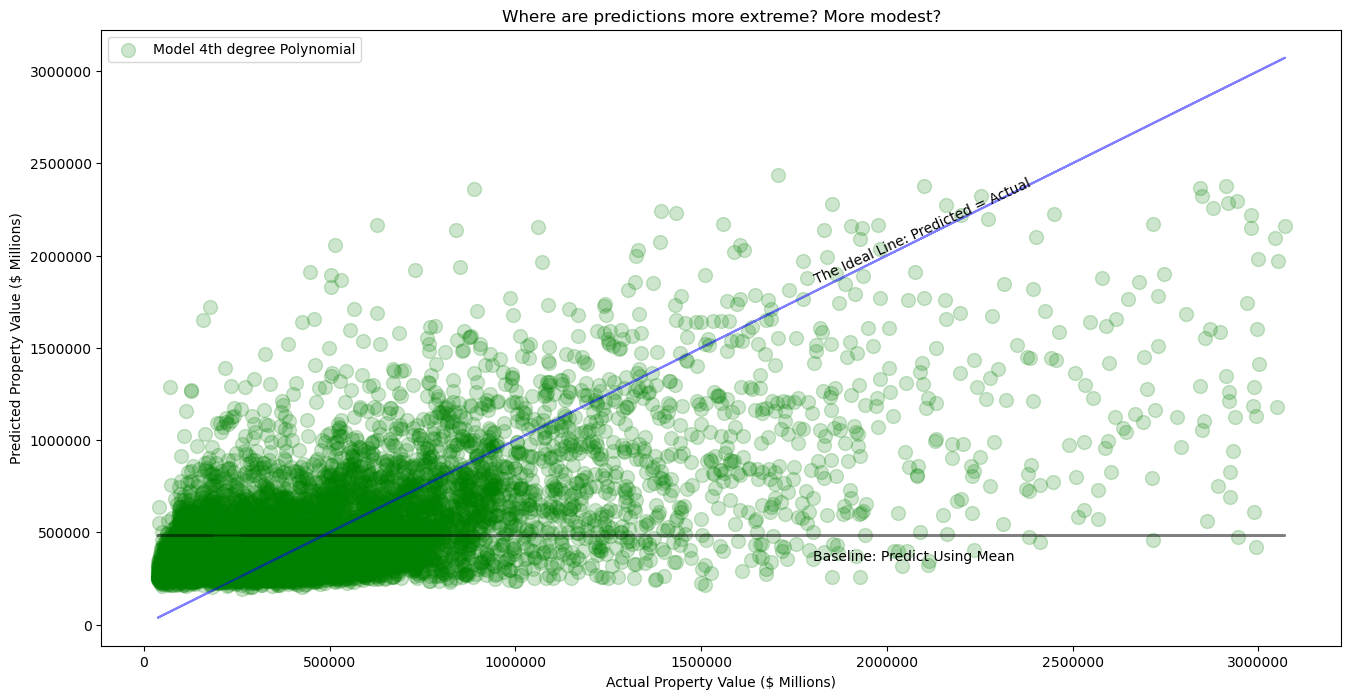

In [50]:
plot_predicted_vs_actual(X_train_rob, y_train, X_test_rob, y_test)